In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, ZeroPadding2D, PReLU, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.layers.experimental.preprocessing import Resizing
#from keras.backend.tensorflow_backend import set_session
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

height_lr = 136
width_lr = 180
channels = 3
shape_lr = (height_lr, width_lr, channels)
shape_hr = (4*height_lr, 4*width_lr, channels)
data_num = 7
data_dir = f"../../datasets/dataset_0{data_num}/"
activation = 'relu'
regularizer = regularizers.l1(10e-10)
adam = Adam(learning_rate=0.0003)
dropout_ratio = 0.25

In [2]:
'''
input_img = Input(shape=(272, 360, 3))

l1_1 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l1_2 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_1)
l1_3 = MaxPooling2D(padding='same')(l1_2)
l1_4 = Dropout(0.25)(l1_3)
l2_1 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_4)
l2_2 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_1)
l2_3 = MaxPooling2D(padding='same')(l2_2)
l3_1 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_3)
encoder = Model(input_img, l3_1)
#encoder.summary()

l4_1 = UpSampling2D()(l3_1)
l4_2 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_1)
l4_3 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_2)
l5_1 = add([l2_2, l4_3])
l5_2 = UpSampling2D()(l5_1)
l5_3 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_2)
l5_4 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_3)
l6_1 = add([l5_4, l1_2])
l6_2 = Conv2D(3, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6_1)
autoencoder = Model(input_img, l6_2)
autoencoder.summary()
'''

"\ninput_img = Input(shape=(272, 360, 3))\n\nl1_1 = Conv2D(64, (3,3), padding='same', activation='relu',\n            activity_regularizer=regularizers.l1(10e-10))(input_img)\nl1_2 = Conv2D(64, (3,3), padding='same', activation='relu',\n            activity_regularizer=regularizers.l1(10e-10))(l1_1)\nl1_3 = MaxPooling2D(padding='same')(l1_2)\nl1_4 = Dropout(0.25)(l1_3)\nl2_1 = Conv2D(128, (3,3), padding='same', activation='relu',\n            activity_regularizer=regularizers.l1(10e-10))(l1_4)\nl2_2 = Conv2D(128, (3,3), padding='same', activation='relu',\n            activity_regularizer=regularizers.l1(10e-10))(l2_1)\nl2_3 = MaxPooling2D(padding='same')(l2_2)\nl3_1 = Conv2D(256, (3,3), padding='same', activation='relu',\n            activity_regularizer=regularizers.l1(10e-10))(l2_3)\nencoder = Model(input_img, l3_1)\n#encoder.summary()\n\nl4_1 = UpSampling2D()(l3_1)\nl4_2 = Conv2D(128, (3, 3), padding='same', activation='relu',\n            activity_regularizer=regularizers.l1(10e-10

In [3]:
input_img = Input(shape_lr)

l1_1 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l1_2 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_1)
l1_3 = MaxPooling2D(padding='same')(l1_2)
l1_4 = Dropout(0.25)(l1_3)
l2_1 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_4)
l2_2 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_1)
l2_3 = MaxPooling2D(padding='same')(l2_2)
l3_1 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_3)

l4_1 = UpSampling2D()(l3_1)
l4_2 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_1)
l4_3 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_2)
l5_1 = add([l2_2, l4_3])
l5_2 = UpSampling2D()(l5_1)
l5_3 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_2)
l5_4 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_3)
l6_1 = add([l5_4, l1_2])
l6_2 = UpSampling2D()(l6_1)
l6_3 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l6_2)
l6_4 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l6_3)
l7 = Conv2D(3, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6_4)
autoencoder = Model(input_img, l7)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 136, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 136, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 136, 180, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 68, 90, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [4]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=8, dim=(272, 360, 3),
                    n_channels=1, n_classes=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        #print(list_IDs)

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(f'Batch index: {index}')
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'full', filename)
                image_y = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'half', filename)
                image_x = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        #print(f'Y: {Y[10, 10, :]}')
        #print(f'X: {X[10, 10, :]}')
        #print(f'Length of X: {len(X)}')
        return X, Y

In [6]:
files = os.listdir(data_dir+'full')
dataGenerator = DataGenerator(files[:10000])
history = autoencoder.fit(dataGenerator, verbose=1)

1250/1250 [==============================] - 166s 133ms/step - loss: 0.0027


[0.06568627 0.07745098 0.01568627]
[[0.06568627 0.07745098 0.01568627]]


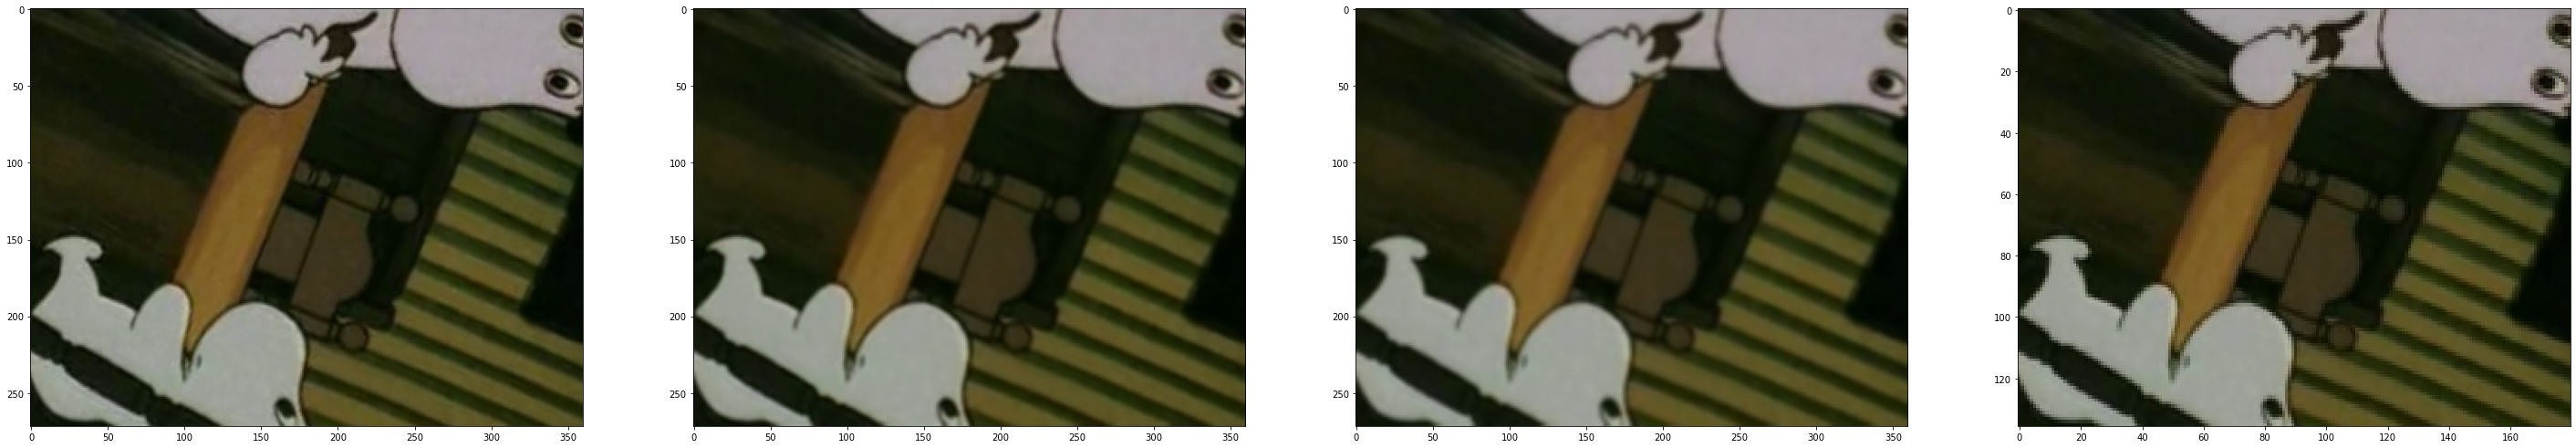

In [9]:
test_image = files[random.randint(0, len(files))]
#test_image = files[100]
test_image = pyplot.imread(os.path.join(data_dir+'full', test_image))
small_image = resize(test_image,(test_image.shape[0]//2, test_image.shape[1]//2))
print(small_image[10, 10, :])
pred_image = np.expand_dims(small_image, 0)
print(pred_image[:, 10, 10, :])
pred_image = 255 * autoencoder.predict(pred_image)
#print(pred_image[0][:10])
pred_image = np.array(pred_image, dtype=int)
#mse_og = np.square(test_image - small_image).mean(axis=None)
#mse = np.square(test_image - pred_image).mean(axis=None)
#print(f'MSE:\nOriginal: {mse_og}\nAutoencoder: {mse}')
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(test_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(pred_image[0])
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(small_image, (2*small_image.shape[0], 2*small_image.shape[1])))
ax = plt.subplot(10, 10, 4)
plt.imshow(small_image)

In [30]:
print(pred_image[0].shape)
print(test_image[0][:10])
print(pred_image[0][:10])

(272, 360, 3)
[[42 34 23]
 [42 34 23]
 [42 34 21]
 [42 34 21]
 [42 34 21]
 [42 34 21]
 [42 34 21]
 [42 34 21]
 [43 33 21]
 [44 34 22]]
[[[41 41 28]
  [43 38 25]
  [39 32 20]
  ...
  [56 49 60]
  [58 51 61]
  [53 55 58]]

 [[41 39 26]
  [41 35 24]
  [40 33 22]
  ...
  [57 48 63]
  [57 46 66]
  [55 56 64]]

 [[42 35 23]
  [40 31 24]
  [39 31 23]
  ...
  [56 46 63]
  [55 44 63]
  [54 50 66]]

 ...

 [[45 37 24]
  [47 35 26]
  [45 34 24]
  ...
  [65 58 77]
  [67 62 80]
  [64 64 79]]

 [[46 37 25]
  [48 35 27]
  [46 34 25]
  ...
  [67 60 81]
  [66 62 81]
  [62 62 78]]

 [[47 37 25]
  [49 35 28]
  [47 35 26]
  ...
  [69 61 82]
  [65 61 81]
  [60 60 76]]]


In [26]:
full_image = pyplot.imread(os.path.join('../../datasets/full_frames', '3.jpg'))
full_size = full_image.shape
print(full_size)
quater_images = np.empty((16, full_size[0]//2, full_size[1]//2, 3), dtype=float)
quater_images_scaled = np.empty((16, full_size[0]//2, full_size[1]//2, 3), dtype=float)
scaled_image = np.empty((full_size[0]*2, full_size[1]*2, 3), dtype=float)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0])
        x_e = int(((i+1)/4.)*full_size[0])
        y_s = int((j/4.)*full_size[1])
        y_e = int(((j+1)/4.)*full_size[1])
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        temp = full_image[x_s:x_e, y_s:y_e]
        temp = resize(temp,(full_size[0]//2, full_size[1]//2))
        quater_images[k] = temp
        k += 1
print(quater_images.shape)
for i in range(0, 16):
    temp = np.expand_dims(quater_images[i], 0)
    temp = autoencoder.predict(temp)
    quater_images_scaled[i] = temp[:]
print(quater_images_scaled.shape)
print(scaled_image.shape)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0]*2)
        x_e = int(((i+1)/4.)*full_size[0]*2)
        y_s = int((j/4.)*full_size[1]*2)
        y_e = int(((j+1)/4.)*full_size[1]*2)
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #print(scaled_image[x_s:x_e, y_s:y_e].shape)
        scaled_image[x_s:x_e, y_s:y_e] = quater_images_scaled[k]
        k += 1

print(full_image[40][40][:])
print(quater_images[0][10][10][:])
print(quater_images_scaled[0][10][10][:])
print(scaled_image[40][40][:])
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(full_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(scaled_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(quater_images[9])
ax = plt.subplot(10, 10, 4)
plt.imshow(quater_images_scaled[3])

(544, 720, 3)
(16, 272, 360, 3)


ValueError: could not broadcast input array from shape (544,720,3) into shape (272,360,3)

(544, 720, 3)
(16, 136, 180, 3)
(16, 272, 360, 3)
(1088, 1440, 3)
[150 161 119]
[0.58039216 0.62745098 0.43921569]
[0.54979295 0.6057204  0.44788316]
[0.51821977 0.56810343 0.36861259]


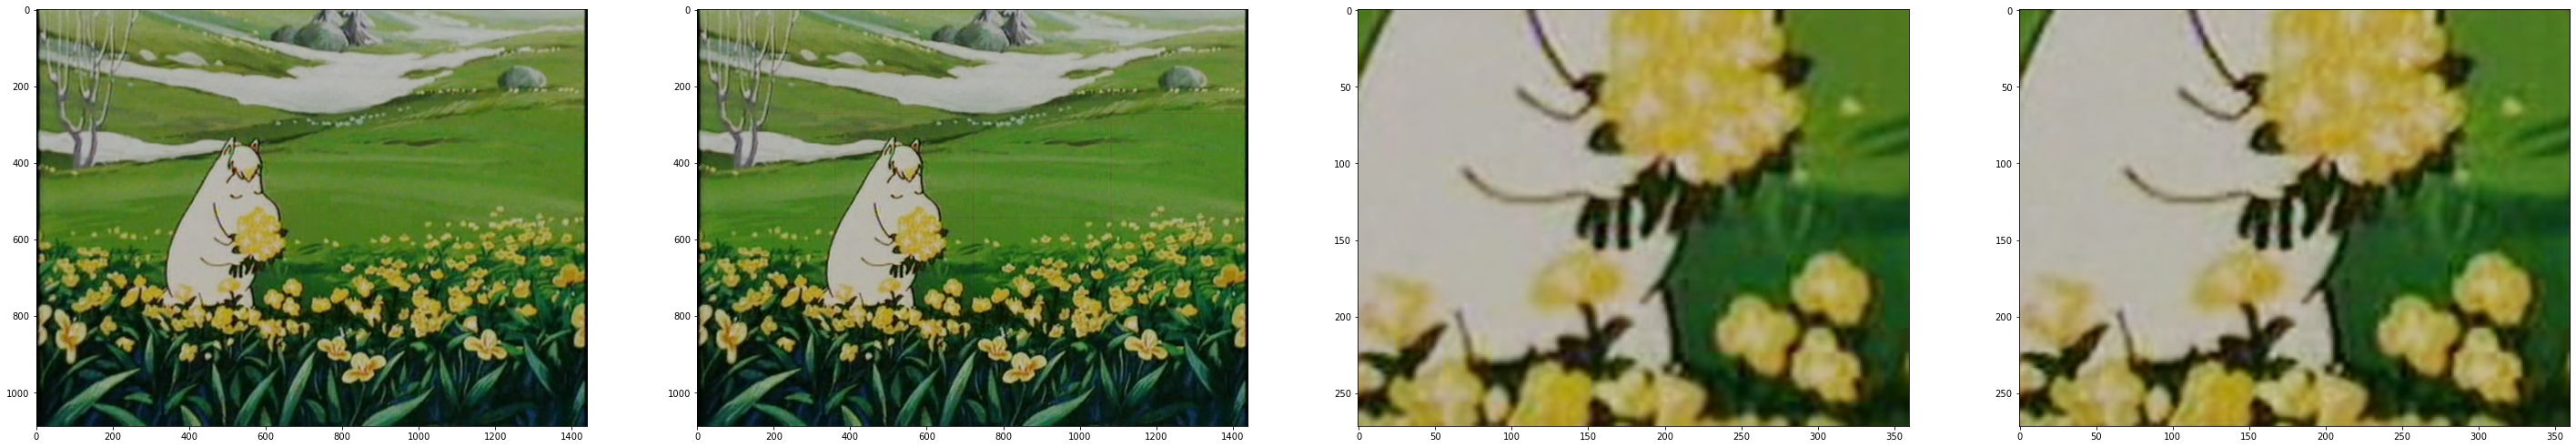

In [10]:
full_image = pyplot.imread(os.path.join('../../datasets/full_frames', '3.jpg'))
full_size = full_image.shape
print(full_size)
quater_images = np.empty((16, full_size[0]//4, full_size[1]//4, 3), dtype=float)
quater_images_scaled = np.empty((16, full_size[0]//2, full_size[1]//2, 3), dtype=float)
scaled_image = np.empty((full_size[0]*2, full_size[1]*2, 3), dtype=float)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0])
        x_e = int(((i+1)/4.)*full_size[0])
        y_s = int((j/4.)*full_size[1])
        y_e = int(((j+1)/4.)*full_size[1])
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #temp = full_image[x_s:x_e, y_s:y_e]
        #temp = resize(temp,(full_size[0]//2, full_size[1]//2))
        quater_images[k] = (1./255) * full_image[x_s:x_e, y_s:y_e]
        k += 1
print(quater_images.shape)

for i in range(0, 16):
    temp = np.expand_dims(quater_images[i], 0)
    temp = autoencoder.predict(temp)
    quater_images_scaled[i] = temp[:]
print(quater_images_scaled.shape)
print(scaled_image.shape)

k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0]*2)
        x_e = int(((i+1)/4.)*full_size[0]*2)
        y_s = int((j/4.)*full_size[1]*2)
        y_e = int(((j+1)/4.)*full_size[1]*2)
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #print(scaled_image[x_s:x_e, y_s:y_e].shape)
        scaled_image[x_s:x_e, y_s:y_e] = quater_images_scaled[k]
        k += 1

print(full_image[40][40][:])
print(quater_images[0][10][10][:])
print(quater_images_scaled[0][10][10][:])
print(scaled_image[40][40][:])
seqment = 9
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(resize(full_image, (2*full_size[0], 2*full_size[1])))
ax = plt.subplot(10, 10, 2)
plt.imshow(scaled_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quater_images[seqment], (2*quater_images.shape[1], 2*quater_images.shape[2])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quater_images_scaled[seqment])